In [16]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Activation, Conv2D, MaxPooling2D,UpSampling2D, Input, Conv2DTranspose, Concatenate, ReLU
from keras.layers import BatchNormalization as BN
from keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal

In [3]:
!wget https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
!wget https://www.dropbox.com/s/gstpamhin8rlhlg/masks.npy

--2023-04-03 10:39:05--  https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/qii26wuxcbxw169/images.npy [following]
--2023-04-03 10:39:05--  https://www.dropbox.com/s/raw/qii26wuxcbxw169/images.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7dc79ef6f53897a659657f66cd.dl.dropboxusercontent.com/cd/0/inline/B5cmMfVblC3LtL2J5_WQajeX38kIuSZGBQR1h5KKW2xAlAqOUjOXvoAjQBVovuhQYnGjNcnHYu71gYxwgkHY5EIZyLNGVsyyBH_KaBSxuwOJLgWGHx57syk7f5grbQwZ0-_37ekfhwmaE3rckchhVHdJXKkS5-Iv946VXw46T_94tw/file# [following]
--2023-04-03 10:39:05--  https://uc7dc79ef6f53897a659657f66cd.dl.dropboxusercontent.com/cd/0/inline/B5cmMfVblC3LtL2J5_WQajeX38kIuSZGBQR1h5KKW2xAlAqOUjOXvoAjQBVovuhQYnGjNcnHYu71gYxwgkHY5E

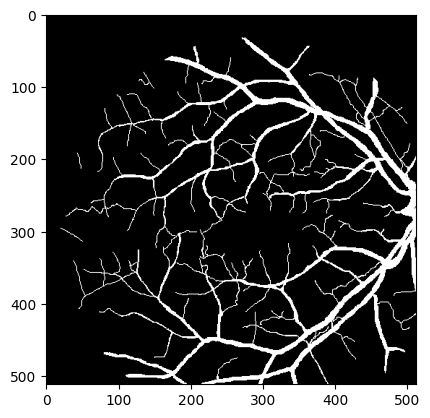

In [4]:
images=np.load("images.npy")
## Crop 512
images=images[:,0:512,0:512,:]
# images = tf.image.resize(images, (224, 224))
# im=Image.fromarray(images[0])
plt.imshow(images[0], cmap=None)

masks=np.load("masks.npy")
## Crop 512
masks=masks[:,0:512,0:512]
masks = masks[..., tf.newaxis]

# Normalize the pixel values of the images and masks
# Subtract mean pixel values to center the pixel values around zero
mean = [103.939, 116.779, 123.68]

images = (images - mean)
# images = (images - mean) / std
masks = (masks - np.min(masks)) / (np.max(masks) - np.min(masks))  # Normalize masks to [0, 1]

plt.imshow(masks[0], cmap='Greys_r')
plt.show()

In [5]:
# Normalize the pixel values to be between 0 and 1
# in_img = images / 255.0
# out_img = masks / 255.0
in_img = images
out_img = masks

# Set up an image data generator with data augmentation
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest',
                    #  rescale=1./255,
                     )
image_data_generator = ImageDataGenerator(**data_gen_args)

# Set up a generator to produce batches of input and output images
def image_generator(batch_size, img_array, mask_array):
    # Create an infinite loop of batches
    while True:
        # Generate a batch of random indices
        idx = np.random.choice(img_array.shape[0], size=batch_size, replace=False)
        # Select the input and output images for this batch
        batch_images = img_array[idx]
        batch_masks = mask_array[idx]
        # Apply the same data augmentation to the input and output images
        seed = np.random.randint(1, 1000)
        batch_images = image_data_generator.flow(batch_images, batch_size=batch_size, seed=seed, shuffle=False).next()
        batch_masks = image_data_generator.flow(batch_masks, batch_size=batch_size, seed=seed, shuffle=False).next()
        # Yield the batch of input and output images
        yield batch_images, batch_masks

# Set the batch size and number of steps per epoch
batch_size = 8
steps_per_epoch = len(images) // batch_size

# Set up the generator for training and validation
train_gen = image_generator(batch_size, in_img, out_img)

In [6]:
# # define downsampling block for Unet
# def encoder_block(filters,con_layer,batchNorm=True):
#   #points from gaussian distribution
#   init = RandomNormal(stddev=0.002)
#   g = Conv2D(filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(con_layer)
#   if batchNorm:
#     g = BN()(g)
#   g = ReLU(0.1)(g)
#   return g

# #define upsampling block for Unet
# def decoder_block(filters,con_layer,skip_layer):
#   #points from gaussian distribution
#   init = RandomNormal(stddev=0.002)
#   g = Conv2DTranspose(filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(con_layer)
#   g = BN()(g)
#   g = Concatenate()([g,skip_layer])
#   g = ReLU()(g)
#   return g

# # define unet model
# def define_unet(inp):
#   #getting points from gaussian distribution
#   init = RandomNormal(stddev=0.02)
#   #Downsampling layers
#   e1 = encoder_block(64,inp,False)
#   e2 = encoder_block(128,e1)
#   e3 = encoder_block(256,e2)
#   e4 = encoder_block(512,e3)
#   e5 = encoder_block(512,e4)
#   e6 = encoder_block(512,e5)
#   e7 = encoder_block(512,e6)
#   #Bottleneck layer
#   b1 = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
#   b1 = Activation('relu')(b1)
#   #Upsampling layers
#   d1 = decoder_block(512,b1,e7)
#   d2 = decoder_block(512,d1,e6)
#   d3 = decoder_block(512,d2,e5)
#   d4 = decoder_block(512,d3,e4)
#   d5 = decoder_block(256,d4,e3)
#   d6 = decoder_block(128,d5,e2)
#   d7 = decoder_block(64,d6,e1)
#   #Output layer
#   g = Conv2DTranspose(1,1,strides=(2,2),padding='same')(d7)
#   return g

In [7]:
# resnet = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(512, 512, 3),
# )
# resnet.trainable = True
# tf.keras.utils.plot_model(resnet, to_file='img.png', show_shapes=True)
# # for i, layer in enumerate(resnet.layers):
# #   if layer.name in ['conv1_conv', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']:
# #     print(i, layer.name, layer.output_shape)

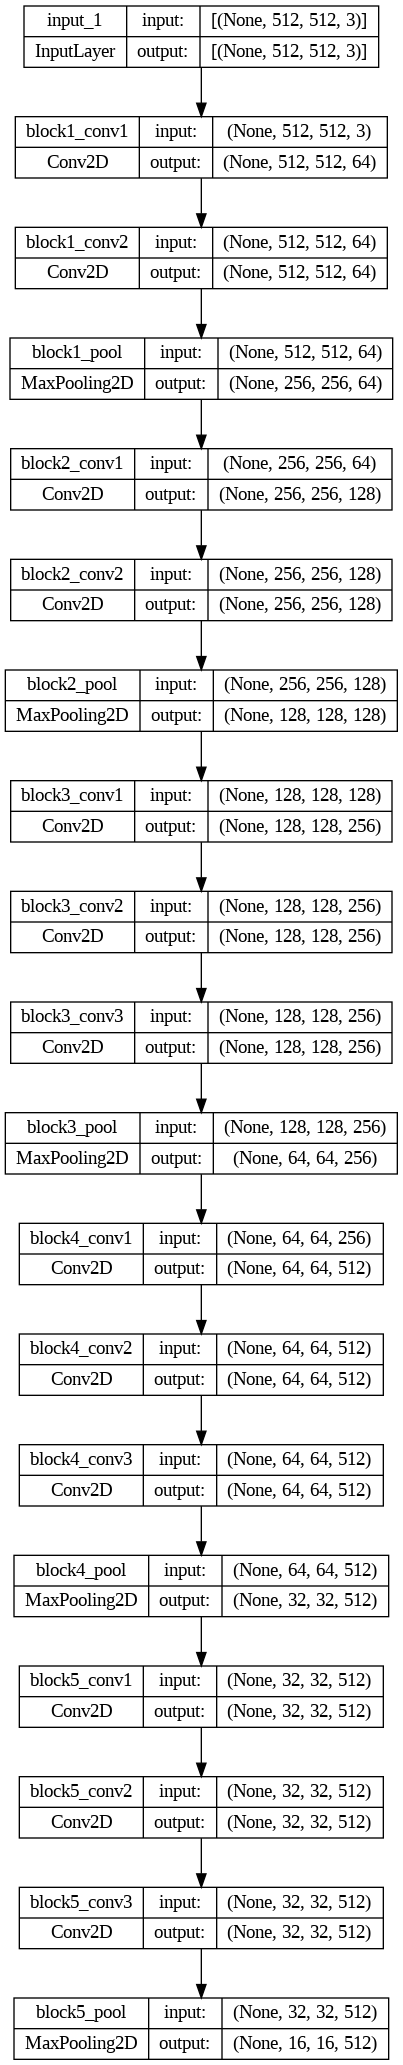

In [8]:
vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(512, 512, 3),
)
vgg.trainable = True
tf.keras.utils.plot_model(vgg, to_file='img.png', show_shapes=True)
# for i, layer in enumerate(vgg.layers):
#   if layer.name in ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']:
#     print(i, layer.name, layer.output_shape)

In [9]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BN())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(ReLU())

  return result

base_model = vgg

# Use the activations of these layers
# layer_names = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = True

up_stack = [
    upsample(512, 3),  # 16x16 -> 32x32
    upsample(256, 3),  # 32x32 -> 64x64
    upsample(128, 3),  # 64x64 -> 128x128
    upsample(64, 3),   # 128x128 -> 256x256
    # upsample(64, 3),   # 256x256 -> 512x512
]

def unet_model(inputs):
  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])

  # This is the last layer of the model
  # last = tf.keras.layers.Conv2DTranspose(
  #     filters=32, kernel_size=3, strides=2,
  #     padding='same')  #64x64 -> 128x128

  # x = last(x)
  x = BN()(x)
  x = ReLU()(x)
  x = Conv2D(1, (1, 1))(x)
  return x

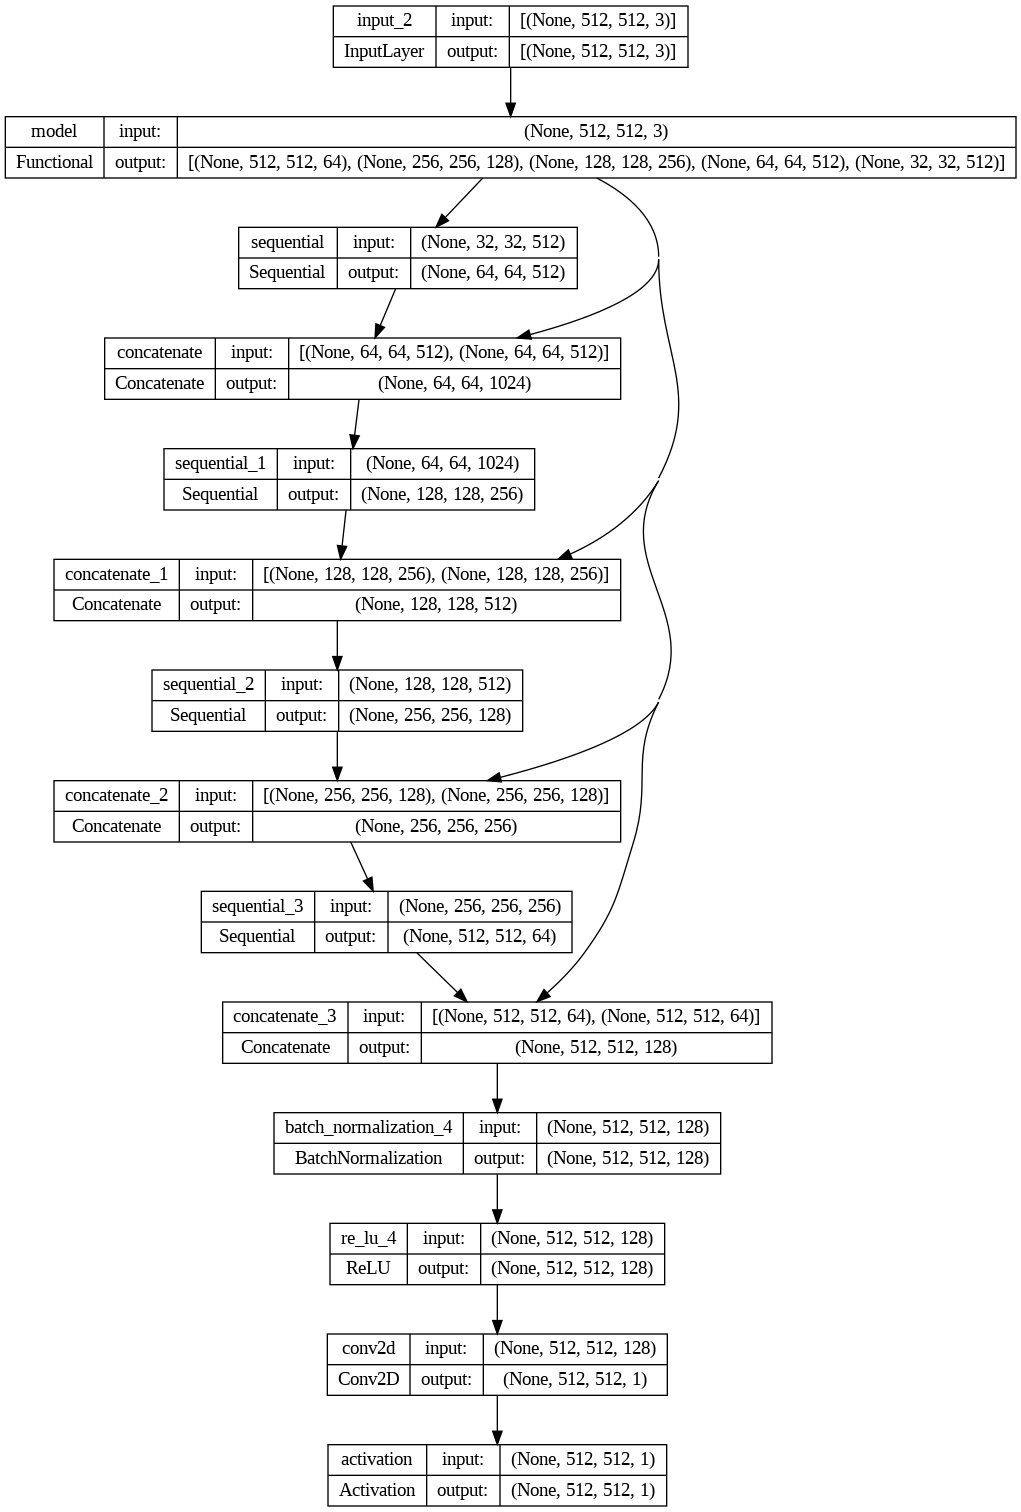

In [10]:
lin=Input((512,512,3))
out=Activation('sigmoid')(unet_model(lin))

opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)

model = Model(inputs=lin, outputs=out)
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

In [11]:
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['mse'])
    
model.summary()

history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=400,verbose=1)

pre_img=model.predict(images)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 512, 512, 6  14714688    ['input_2[0][0]']                
                                4),                                                               
                                 (None, 256, 256, 1                                               
                                28),                                                              
                                 (None, 128, 128, 2                                         

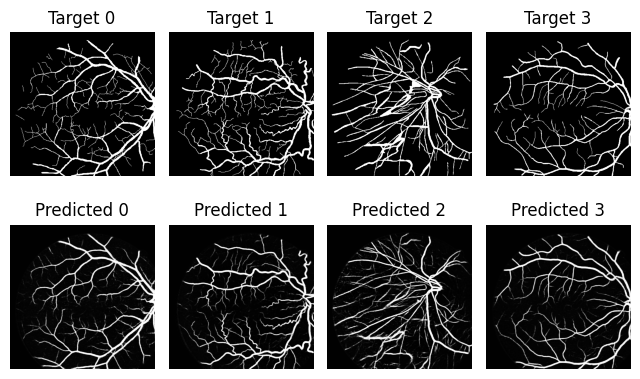

In [12]:
# plt.style.use('default')
# Create the figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(8, 5))

# Set the title for the whole figure
# fig.suptitle("Unet")

# Loop through each row and column to plot the images
for j in range(4):
    
    # Get the current target and predicted images
    target_img = masks[j,:,:]
    predicted_img = pre_img[j,:,:,0]
    
    # Plot the images on the current subplot
    axs[0, j].imshow(target_img, cmap='Greys_r')
    axs[0, j].set_title(f"Target {j}")
    axs[0, j].axis("off")
    
    axs[1, j].imshow(predicted_img, cmap='Greys_r')
    axs[1, j].set_title(f"Predicted {j}")
    axs[1, j].axis("off")

# Remove the space between rows and columns
fig.subplots_adjust(hspace=0, wspace=0.1)
plt.savefig('4.png', bbox_inches='tight')
# Show the figure
plt.show()

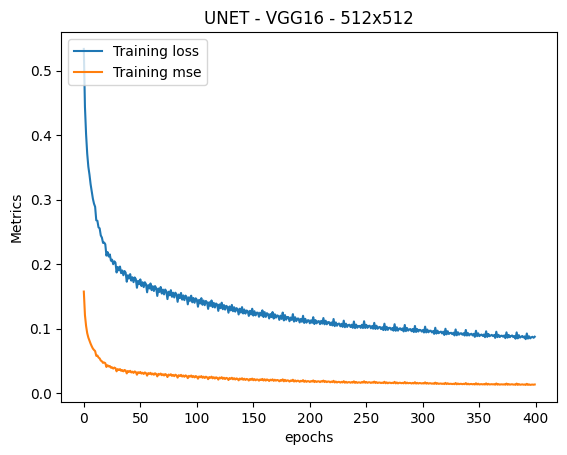

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['mse'])
plt.title('UNET - VGG16 - 512x512')
plt.ylabel('Metrics')
plt.xlabel('epochs')
plt.legend(['Training loss', 'Training mse'], loc='upper left')
plt.show()